# Problem statement

> For Health-stroke-data.csv 

* Plot charts and explain them in words(min 2 charts)
* Check if “BMI” column has null values? what is the percentage of null values ? use data engineering method to fill the null values.
* Remove outliers from any two numerical columns using any appropriate ML technique
* Perform Scaling on all numerical columns
* Perform Encoding on all categorical columns
* Generate at least 2 new features using existing features of your choice.


### Loading data

**Attribute Dictionary** 
* `id`: unique identifier
* `gender`: "Male", "Female" or "Other"
* `age`: age of the patient
* `hypertension`: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
* `heart_disease`: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
* `ever_married`: "No" or "Yes"
* `work_type`: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
* `Residence_type`: "Rural" or "Urban"
* `avg_glucose_level`: average glucose level in blood
* `bmi`: body mass index
* `smoking_status`: "formerly smoked", "never smoked", "smokes" or "Unknown"*
* `stroke`: 1 if the patient had a stroke or 0 if not

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
import scipy.stats

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data Description

>`Total Records` : 5110 

>`Null Values` : All the attributes had 100% fill rate. But only `BMI` has a has a fill rate of 96% and has 201 missing values which would be later imputed using `Simple Imputer` or `KNN Imputer`

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
print((df.notnull().sum()/len(df))*100 , "%")

id                   100.000000
gender               100.000000
age                  100.000000
hypertension         100.000000
heart_disease        100.000000
ever_married         100.000000
work_type            100.000000
Residence_type       100.000000
avg_glucose_level    100.000000
bmi                   96.066536
smoking_status       100.000000
stroke               100.000000
dtype: float64 %


In [5]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
np.mean(df)

id                   36517.829354
age                     43.226614
hypertension             0.097456
heart_disease            0.054012
avg_glucose_level      106.147677
bmi                     28.893237
stroke                   0.048728
dtype: float64

In [7]:
pd.Series(np.median(df[['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']], axis=0) , index = ["id","age","hypertension","heart_disease","avg_glucose_level","bmi","stroke"])

id                   36932.000
age                     45.000
hypertension             0.000
heart_disease            0.000
avg_glucose_level       91.885
bmi                        NaN
stroke                   0.000
dtype: float64

In [8]:
np.std(df)

id                   21159.650905
age                     22.610434
hypertension             0.296578
heart_disease            0.226041
avg_glucose_level       45.279129
bmi                      7.853267
stroke                   0.215299
dtype: float64

In [9]:
# np.mean(df.loc[df['stroke'] == 0, 'bmi'])

**Note** :
> `hypertension` and `heart_disease` are not numeric continuous attributes they are cateorical `0 as False` and `1 as True`

> Mean for `BMI` when a person has hearstroke (Stroke == 1) was found to be 30.47  whearas <br>`BMI` when a person dont have hearstroke (Stroke == 0) was found to be 28.8

# Data Analaysis

> Target Column : [stroke]

> categorical Columns : [work_type, Residence_type, smoking_status]

> Numeric Columns: [age, avg_glucose_level, BMI]

> Binary Columns : [hypertension, heart_disease, gender, ever_married]

In [10]:
# Attribute segregation to there respective types

target = ['stroke']
cat_cols = ['work_type', 'Residence_type', 'smoking_status',  'gender']
num_cols =  ['age', 'avg_glucose_level', 'bmi']
bin_cols = ['hypertension', 'heart_disease', 'ever_married']

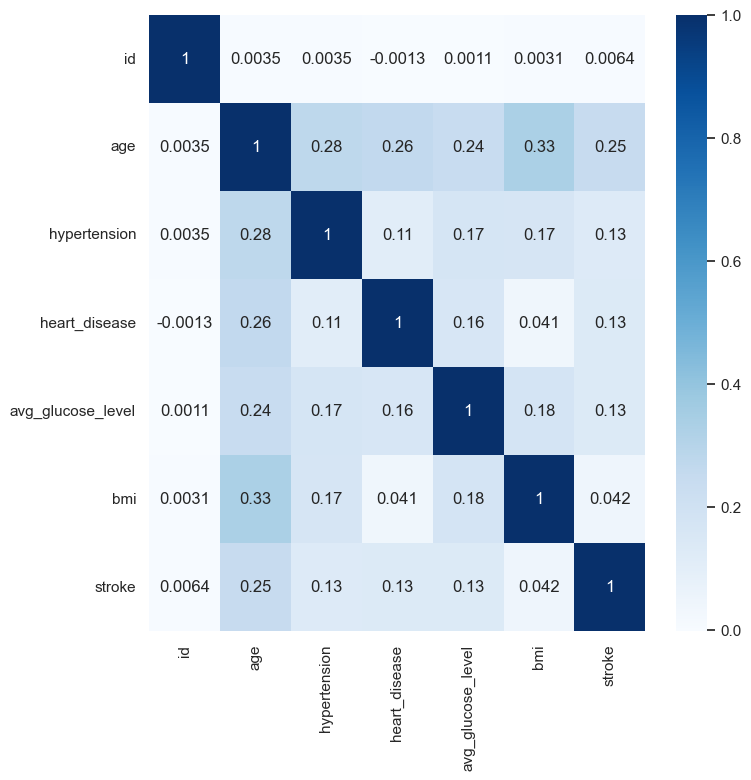

In [12]:
sns.heatmap(df.corr(),cmap="Blues",annot=True)
sns.set(rc={'figure.figsize':(8,8)})

## Univariate Analysis

In [13]:
# function for displaying count plot and pie chart inorder to understand the distribution of the categorical attributes

def count_pie_plot(attribute, df):
    """
    Function to plot a count plot and pie chart side by side.

    params:
        attribute: Name of the categorical attribute column in the DataFrame.
        df: The DataFrame containing the data.

    Returns:
        None (displays the plots).
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    sns.countplot(x=attribute, data=df, ax=axes[0])
    axes[0].set_xlabel(f"{attribute}")
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"Count Plot of {attribute}")

    labels = df[attribute].value_counts().index
    counts = df[attribute].value_counts().values
    num_categories = len(labels)
    colors = sns.color_palette("Set3", num_categories)

    axes[1].pie(counts, labels=labels, colors=colors, autopct="%1.1f%%", startangle=90)
    axes[1].axis("equal")
    axes[1].set_title(f"Pie Chart of {attribute}")

    plt.tight_layout()
    plt.show()
    

# Plots functions  for Numeric Columns 
    
def hist_violin_plot(attribute, df):
    # Create subplots with one row and two columns
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plot the histogram on the first subplot
    axes[0].hist(df[attribute], bins=20, edgecolor='black')
    axes[0].set_xlabel("Age")
    axes[0].set_ylabel("Frequency")
    axes[0].set_title(f"Histogram of {attribute}")

    # Plot the violin plot on the second subplot
    sns.violinplot(x=df[attribute], color='orange', ax=axes[1])
    axes[1].set_xlabel("Age")
    axes[1].set_title(f"Violin Plot of {attribute}")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plots
    plt.show()

###  **1. For Traget Variable `Stroke`**
* High Imbalance in the data as `stroke-0` is 19 times more than `stroke-1`

In [14]:
print(df[target].groupby(target).value_counts())

stroke
0    4861
1     249
dtype: int64


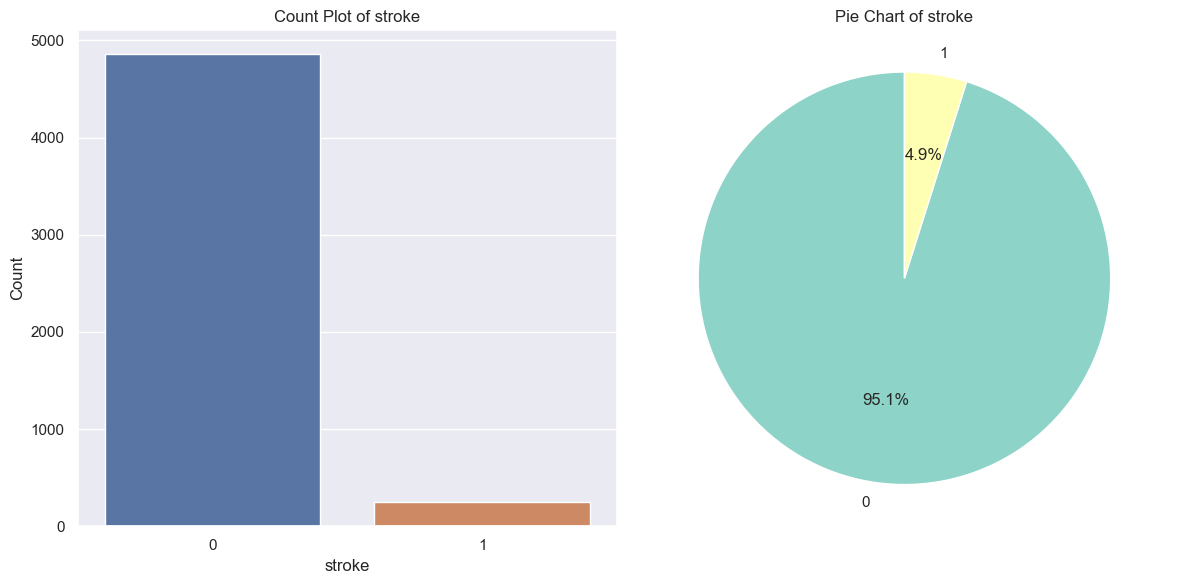

In [15]:
count_pie_plot("stroke",df)

**Note** From the above Graphs we can interprete that there is very high imabalnce in the target variable of the output data 
which can be tackeled by `stratified samping` , `Z score sampling`, `Cluster Sampling` or `SMOTE`

###  **2. For Traget Variable Categorical Variables**

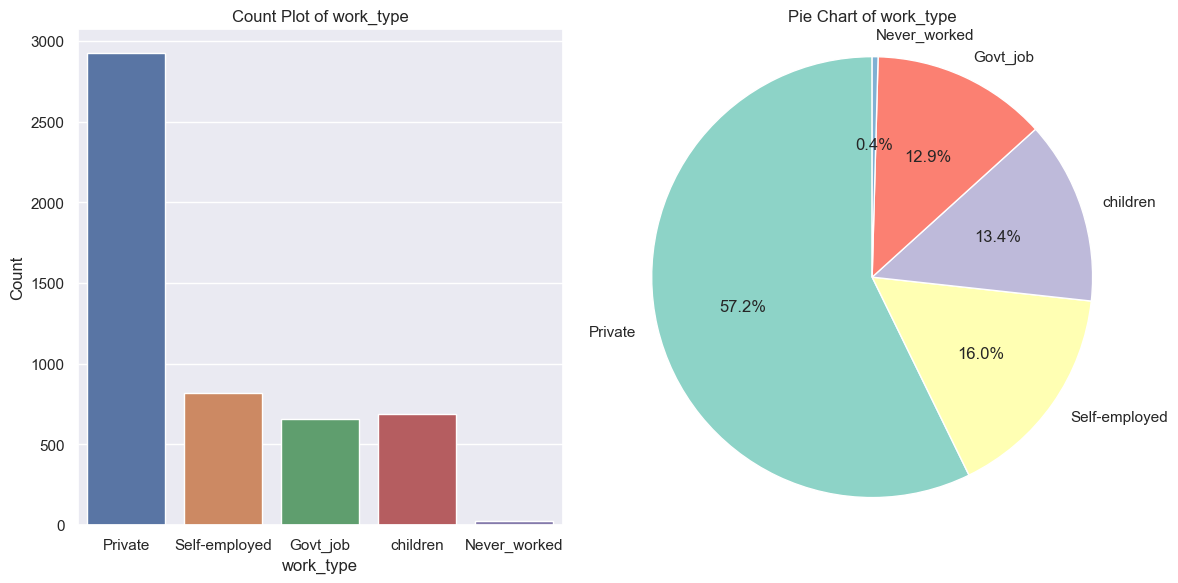

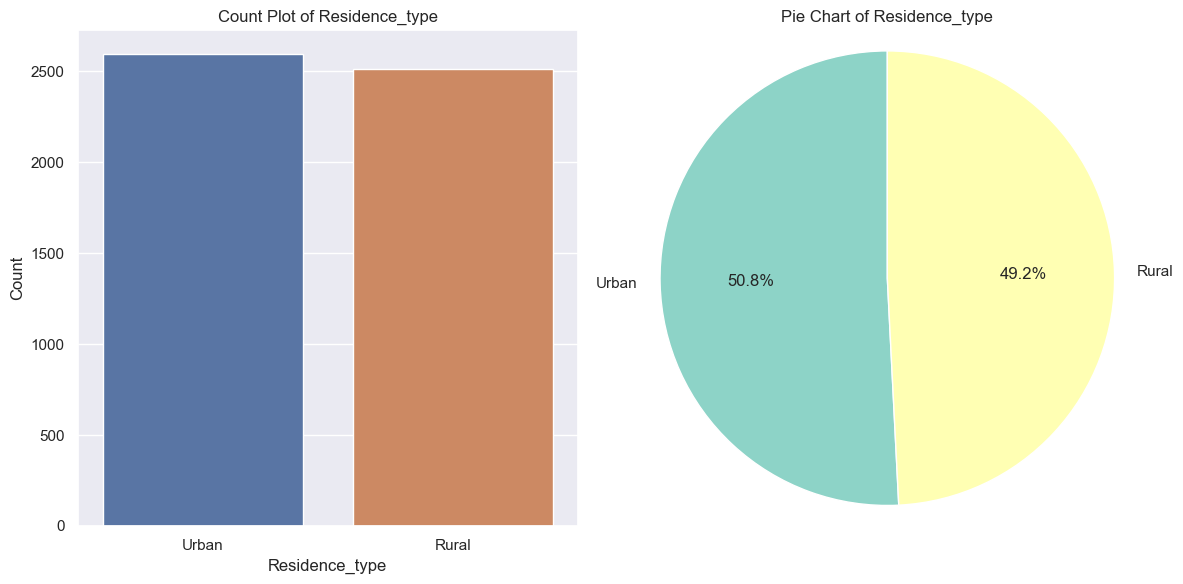

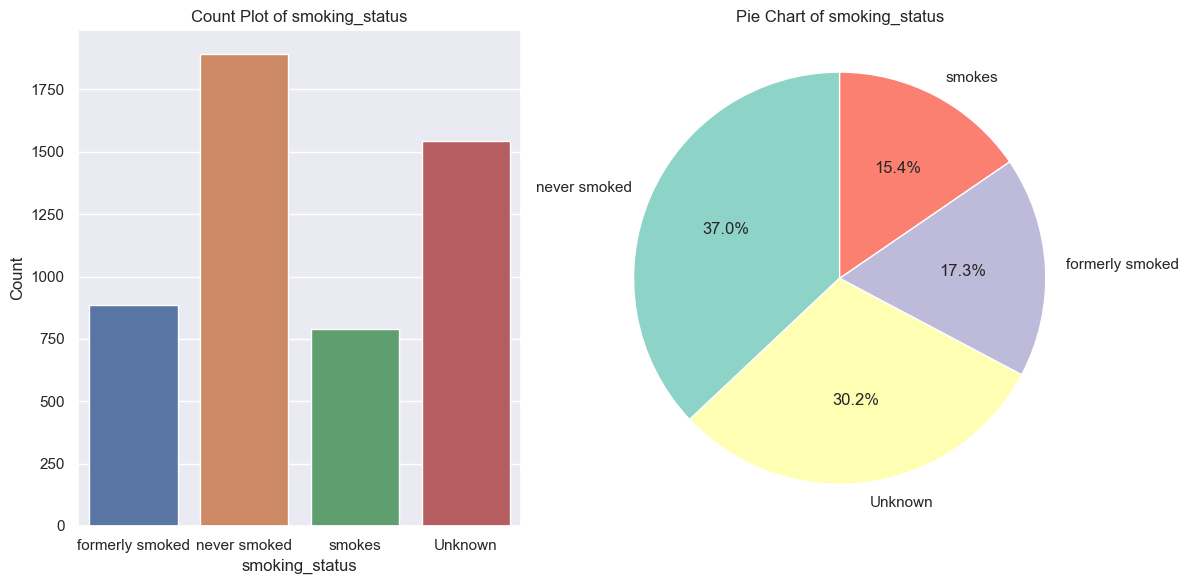

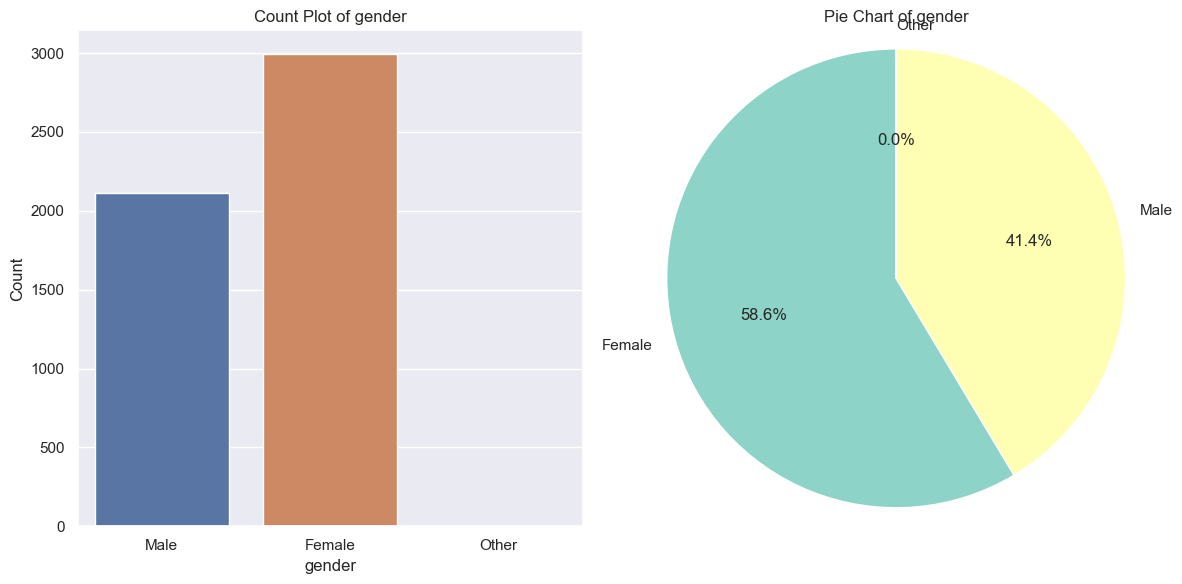

In [16]:
for col in cat_cols:
    count_pie_plot(col,df)

### Description :

>  In the above analysis we can notice for `work_type` we have high population in Private and very few in never_worked

> For `resedential Type` both Urban and Rural are in same Proportion

> For `Smoking_status` there is comapritively even population distribution

>For `Count_plot` the data is evenly distributed for male and female but vey low for Others

###  **3. For Traget Variable Binary Attributes**

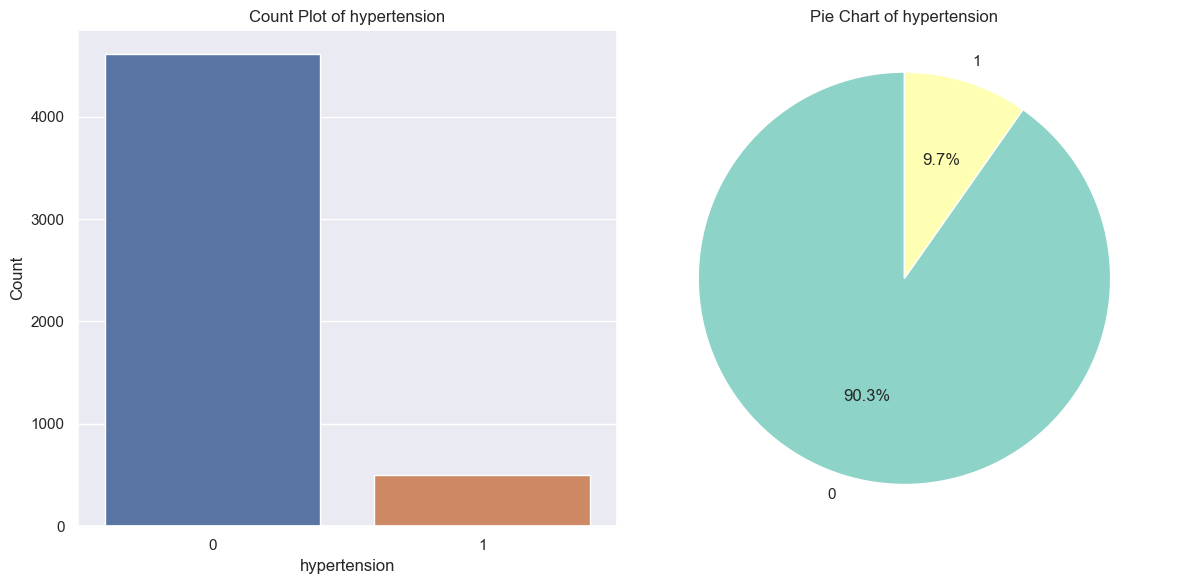

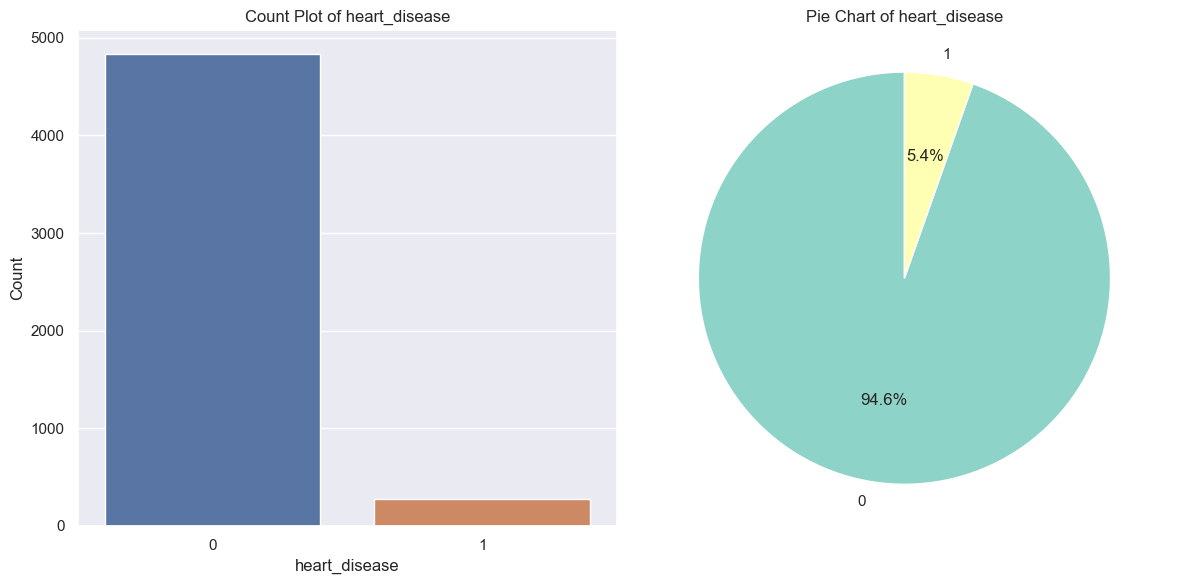

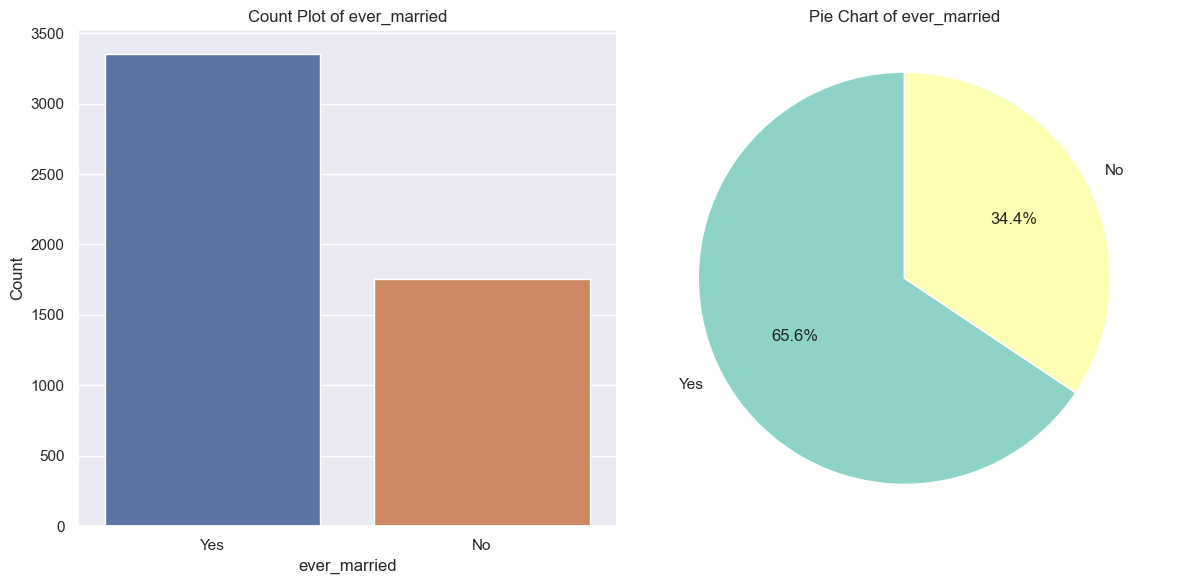

In [17]:
for col in bin_cols:
    count_pie_plot(col,df)

### Descriptions :

> From the above plots we can understand the imbalance in the data for columns `Hypertension` and `heart_disease`
whearas attrbutes like `ever_married` has a good population in the ration of 1:2 for NO:YES

###  **4. For Traget Variable Numeric Attributes**

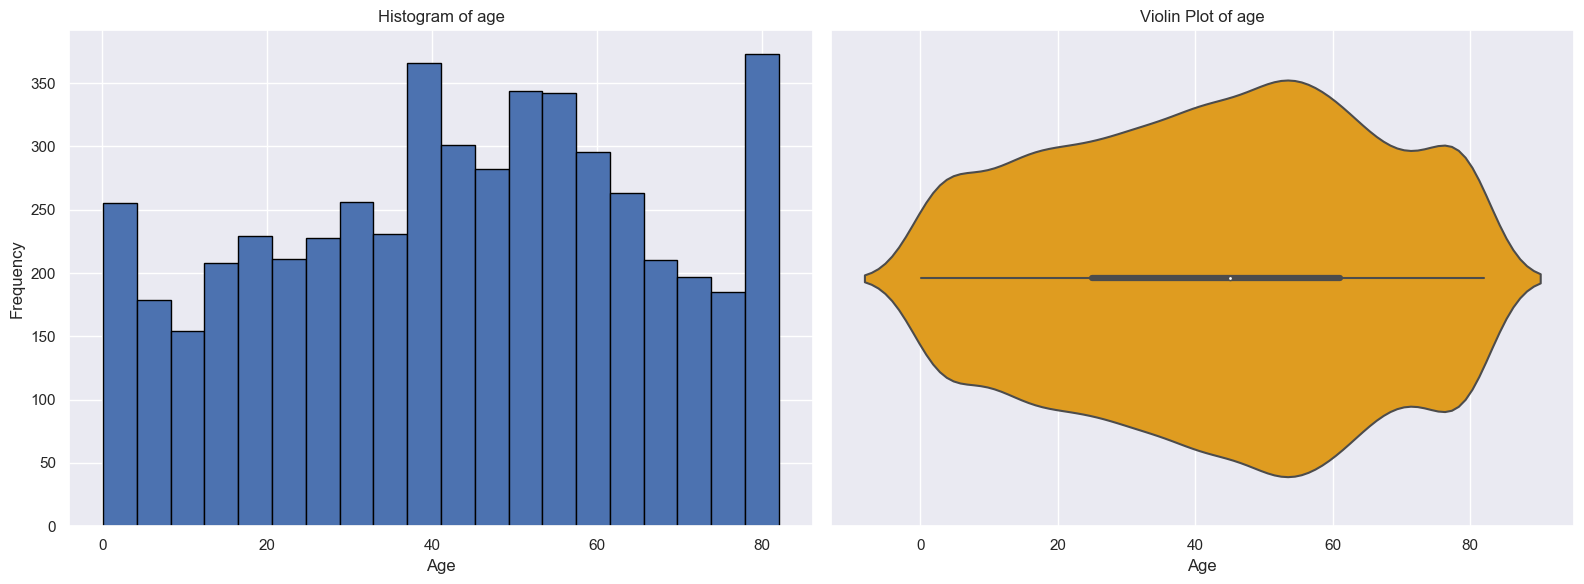

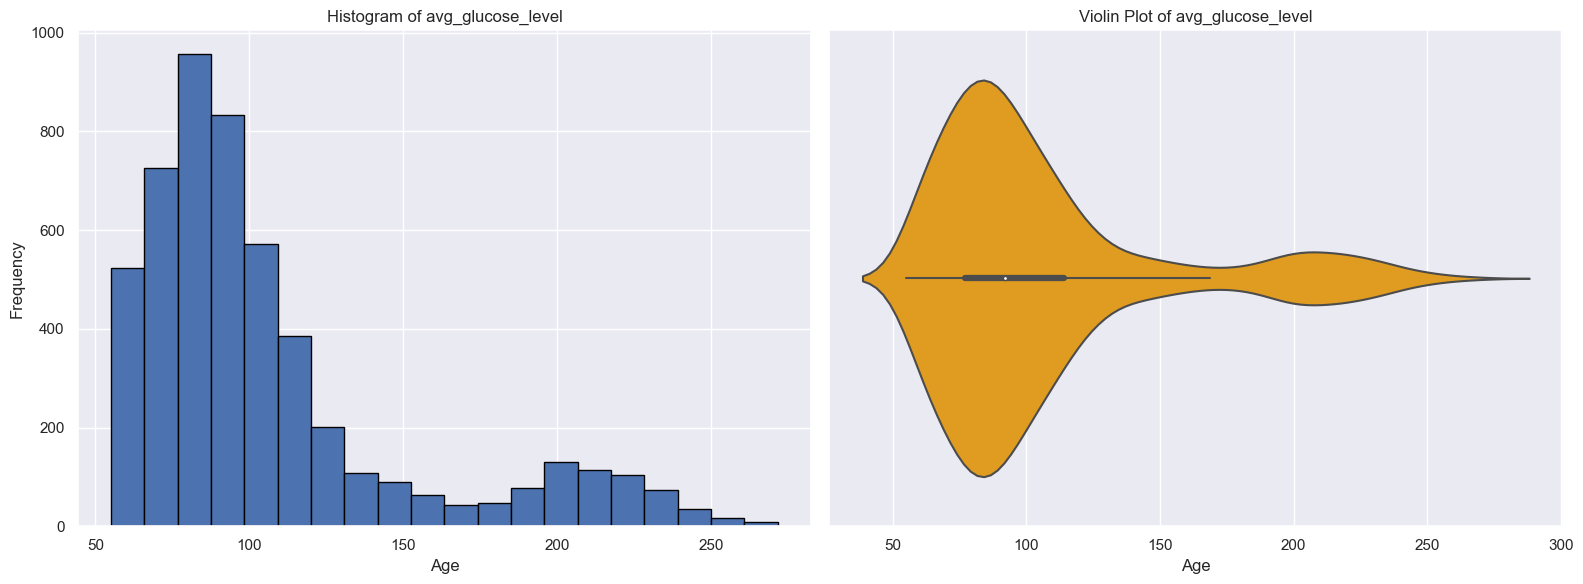

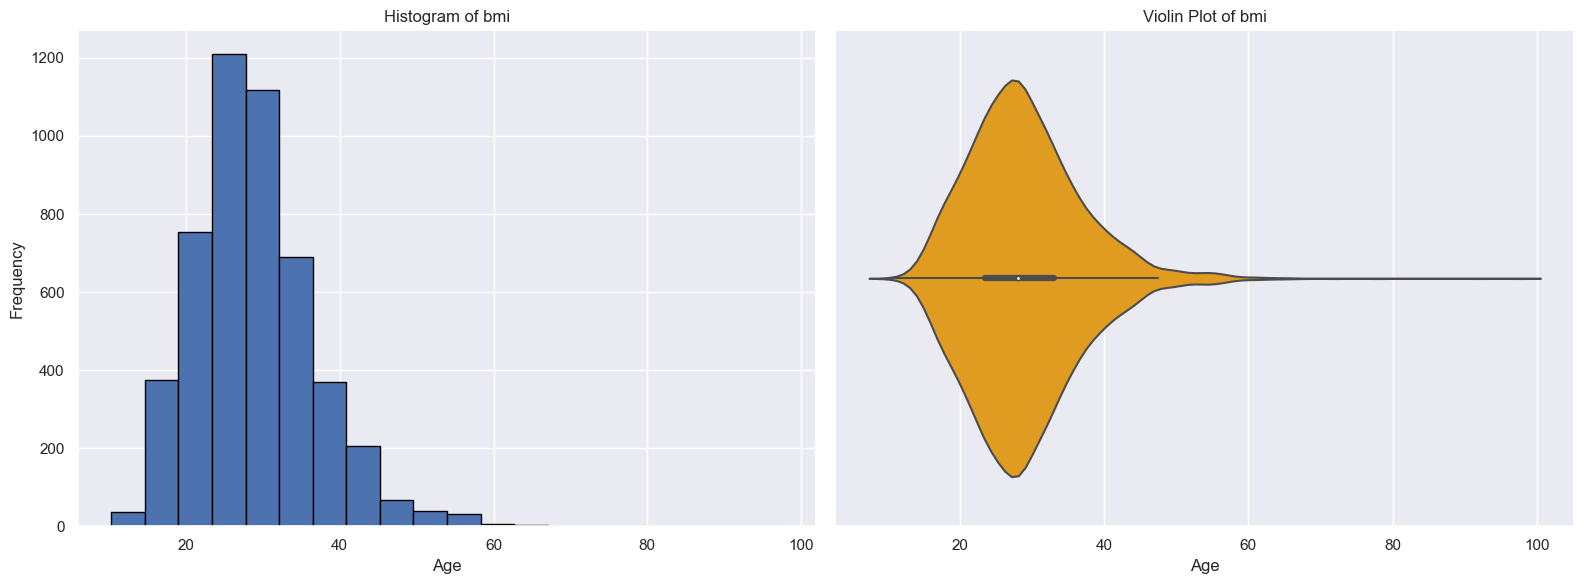

In [18]:
for col in num_cols:
    hist_violin_plot(col, df)

## Bivariate Analaysis

**Functions for Visualization**

In [19]:
# for categorical
def count_bivariate_plot(attribute, df):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='stroke', hue=attribute, data=df)
    plt.xlabel('Stroke')
    plt.ylabel('Count')
    plt.title(f'Count Plot of Stroke by {attribute}')
    plt.legend(title=attribute)
    plt.show()

### 1. For Numeric data

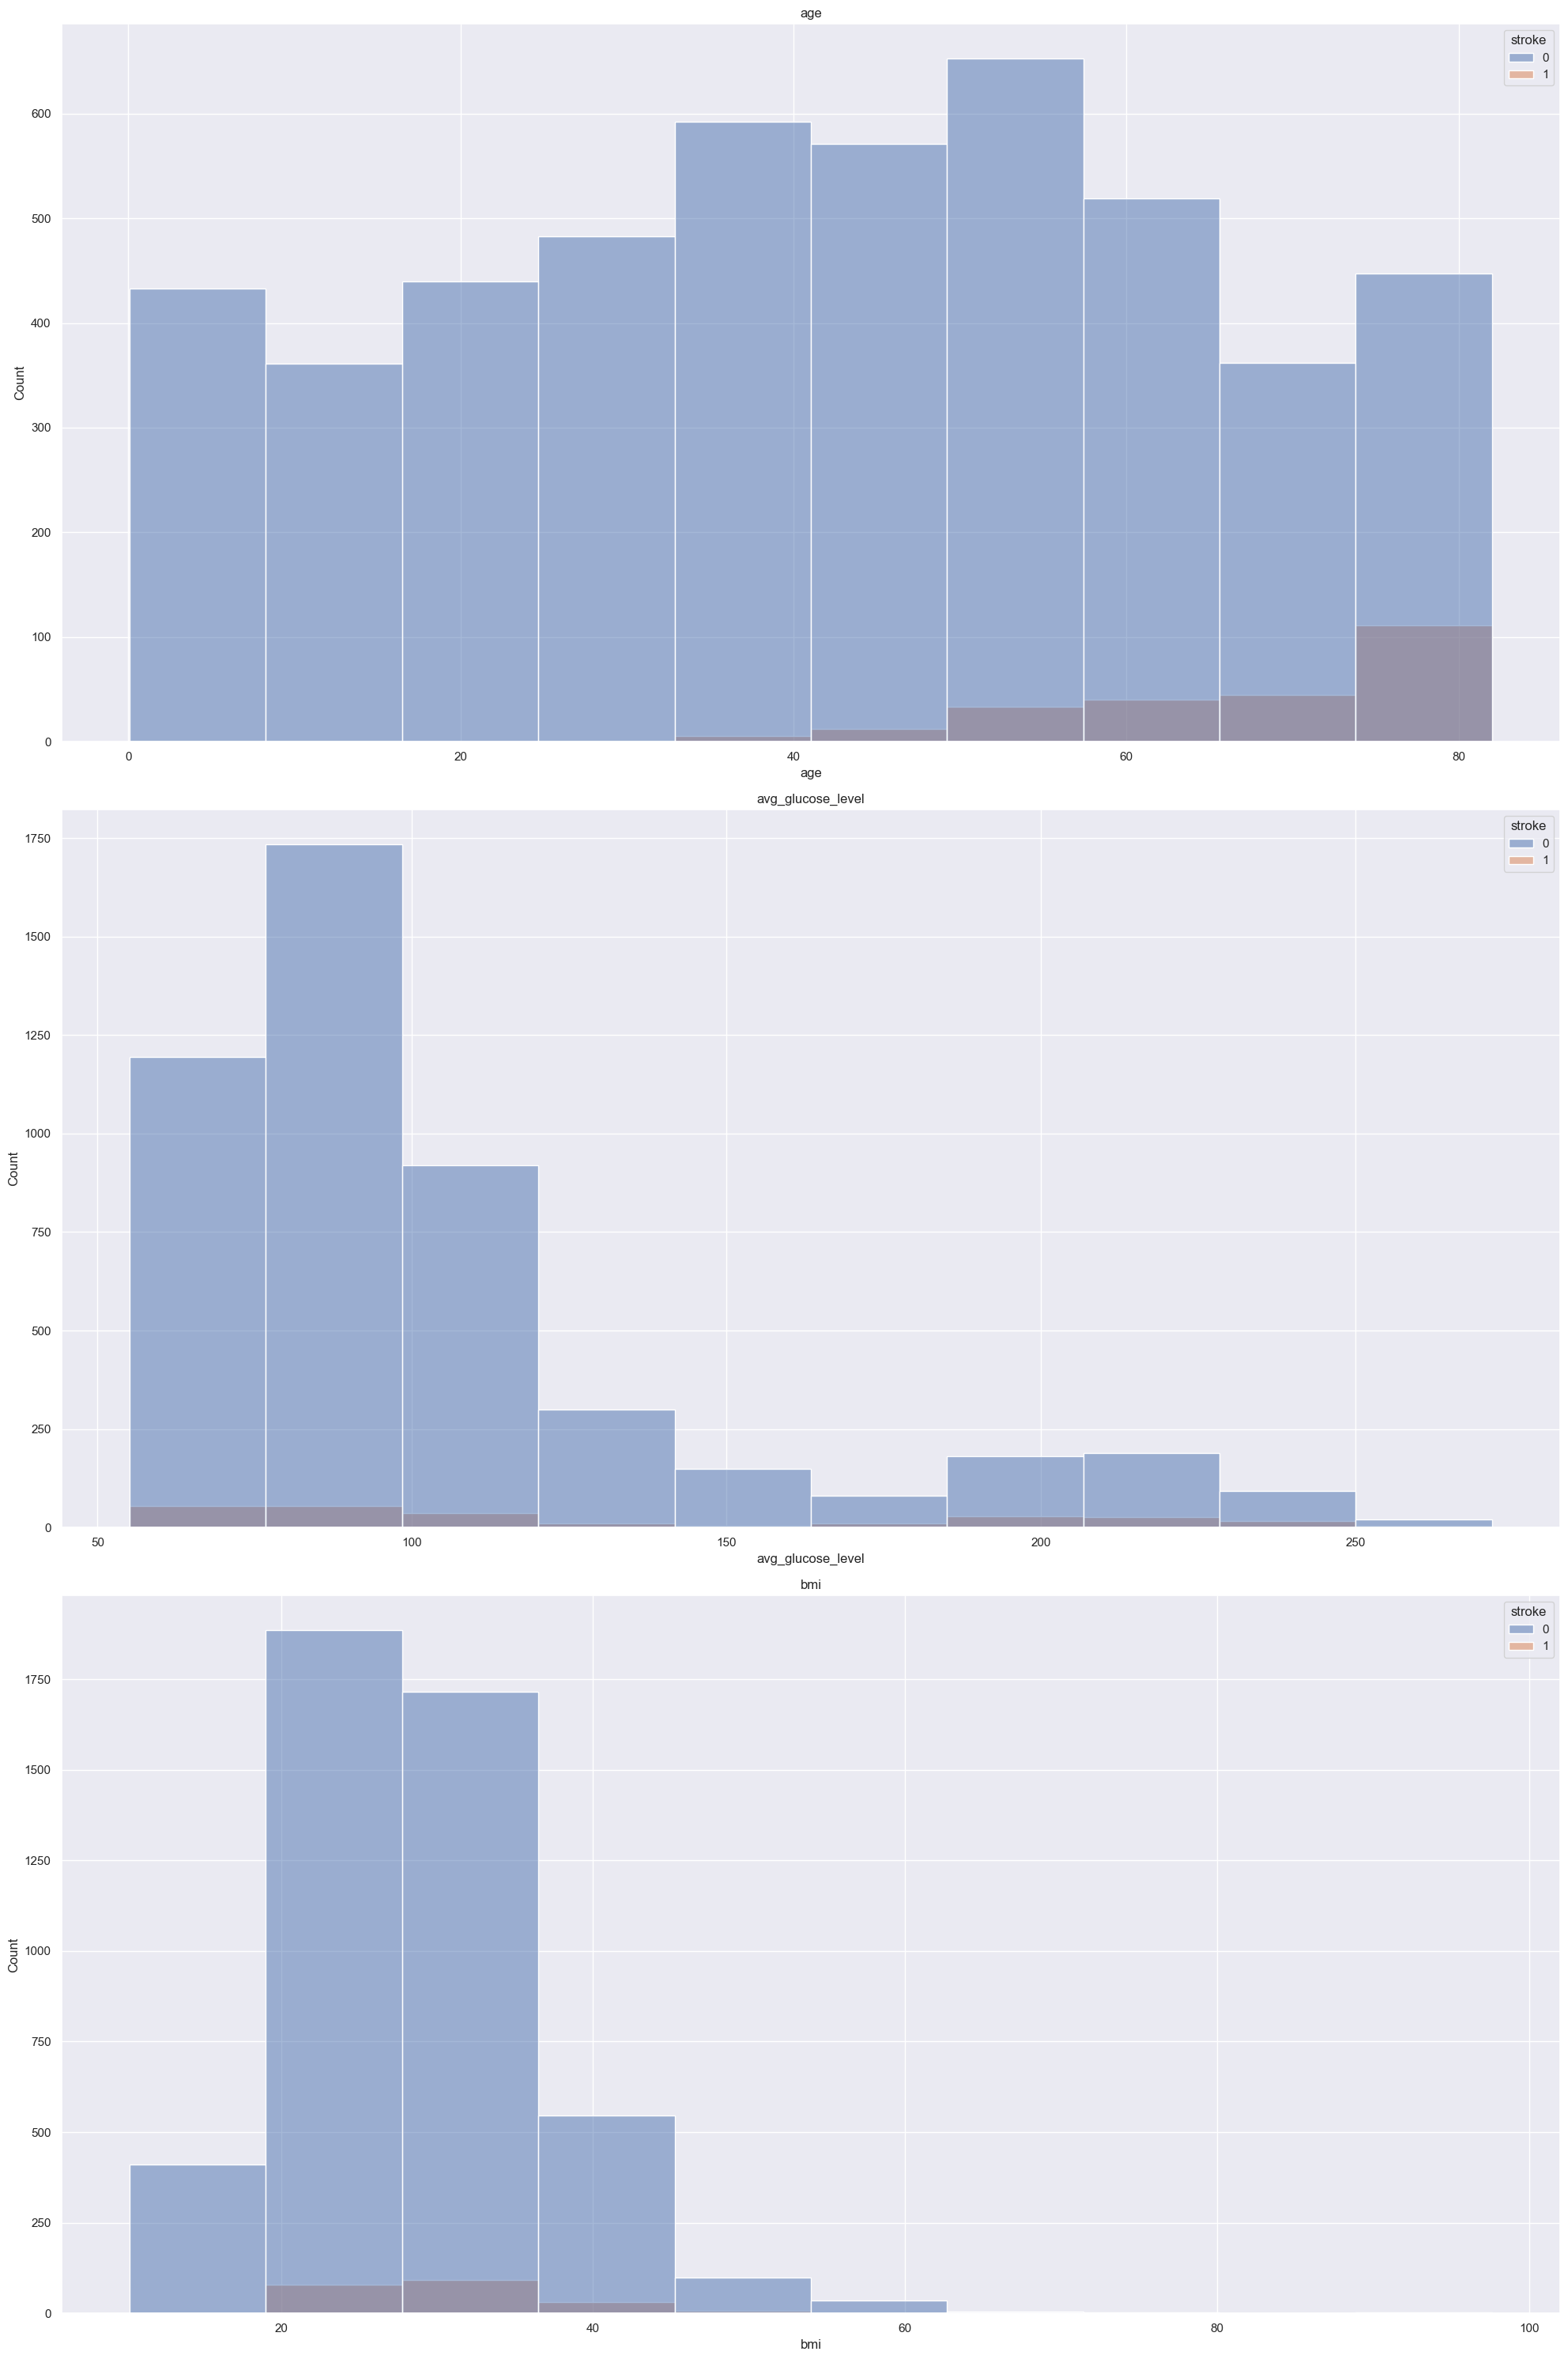

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 30))
axes = axes.flatten()

for i, column in enumerate(num_cols):
    ax = axes[i]
    sns.histplot(data=df, x=column, bins=10, hue='stroke', ax=ax,legend=True)
    ax.set_title(column)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

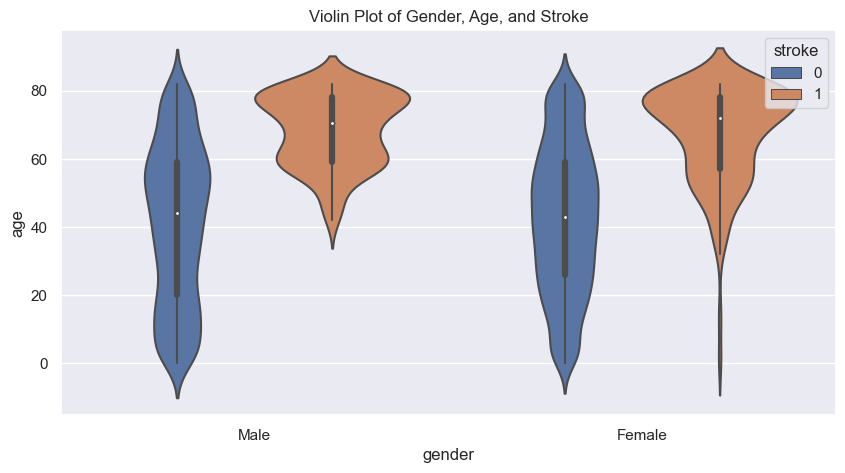

In [21]:
filtered_dataset = df[df["gender"] != "Other"]
plt.figure(figsize=(10,5))
sns.violinplot(x="gender", y="age", hue="stroke", data=filtered_dataset)
plt.title("Violin Plot of Gender, Age, and Stroke")
plt.show()

### Description:  
> In the above vilion plot of Gender Age and Stroke we can see for `female` the width of the violine certainly increase from range 50 - 80 

> In this violin Plot age is more varied across male with `Stroke` around old age like around 75 years of age and the same can be said about the female and for both male and female that doesn't `Stroke` is somewhat evenly varied

C:\Users\mpatil1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mpatil1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 27.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mpatil1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 34.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\mpatil1\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\categorical.py:3544: UserWarning: 49.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings

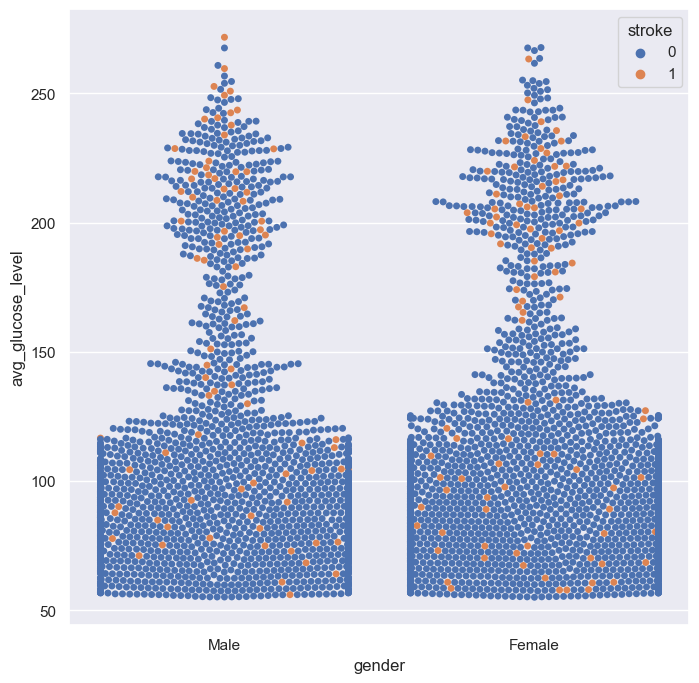

In [22]:
sns.swarmplot(x="gender",y="avg_glucose_level",hue="stroke",data=df[df["gender"]!="Other"])
sns.set(rc={'figure.figsize':(20,15)})

### Description : 
> In this swarmplot we can see that female with low avg_glucose_level are more in quantity than male with low avg_glucose_level with more Chances of a stroke

### 2. For categorical Data

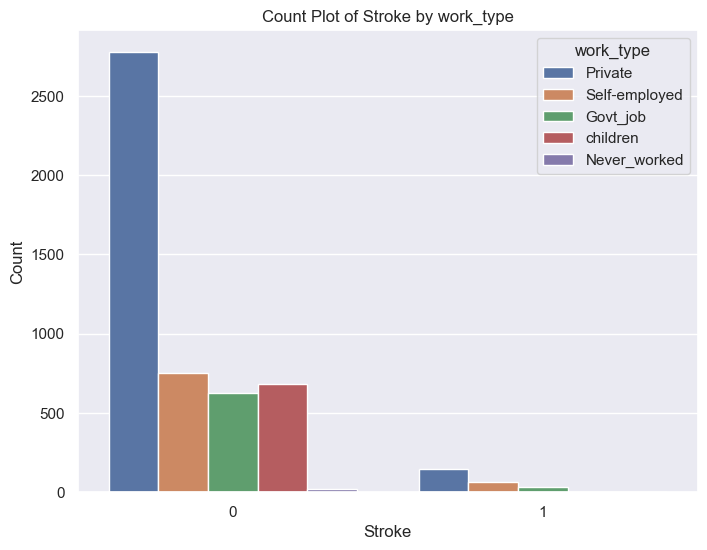

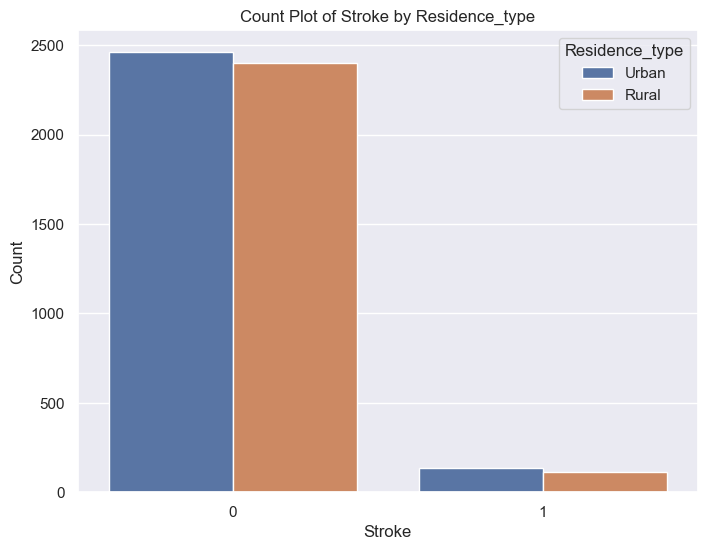

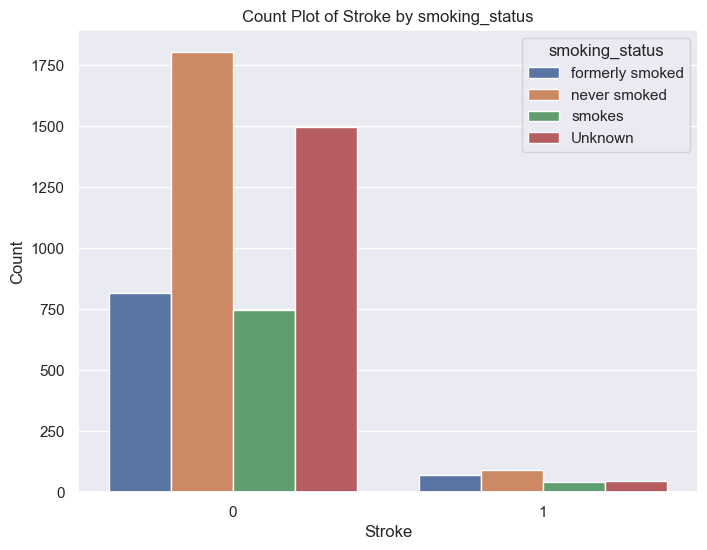

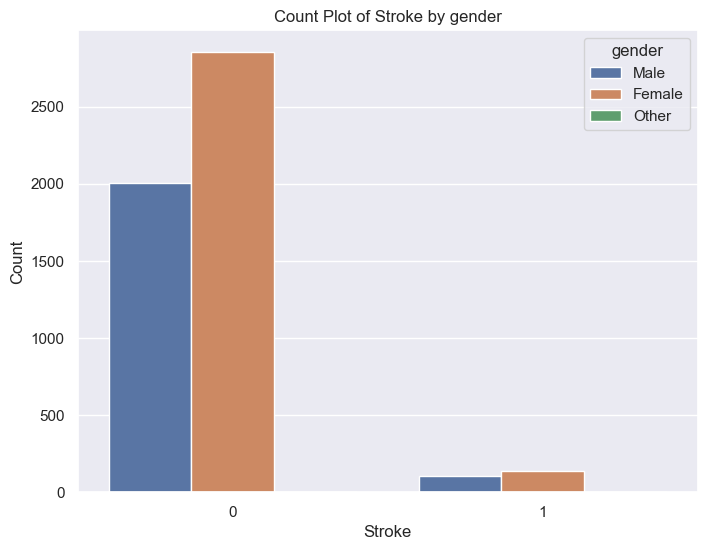

In [23]:
for col in cat_cols:
    count_bivariate_plot(col,df)
    

**Description** : 
> `Smoking Status` : Here in this countplot we can see that a individual who has  `smoked` or `formerly smoked` has the significant increase in count for having `stroke`

> `Residence type` : Data imbalances

> `Work type` : Imabalnces in the data Childernes and People who never worked had very small records allmost zero

# Statistical Tests : 

> `Point Bi Serial` : This test is used to assess the relationship between a binary variable and a Continuous variable.

> `Chi -Sqaure Test` : This test is used to assess the relationship between a binary variable and a Categorical variable.

In [24]:
# Function decalarations 
def correlation_numerical_attribute(df, num_col, target_col):
    df = df[[num_col, target_col]].dropna()
    df[num_col] = df[num_col].astype(float)
    pointbiserial_corr = stats.pointbiserialr(df[num_col], df[target_col])[0]
    # print(pointbiserial_corr)
    return pointbiserial_corr

def categorical_binary_correlation(df, cat_col, target_col):
    contingency_table = pd.crosstab(df[cat_col], df[target_col])
    chi2, p_value, _, _ = scipy.stats.chi2_contingency(contingency_table)
    return chi2, p_value

In [25]:
for column in num_cols:
    corr_score = correlation_numerical_attribute(df, column, 'stroke')
    print(f"{column} -  {corr_score}")

age -  0.24525734617096592
avg_glucose_level -  0.1319454408257056
bmi -  0.04237366114923526


In [26]:
for col in (cat_cols+bin_cols):
  statistic, p_value = categorical_binary_correlation(df, col, 'stroke')
  print(f'{col} -  {statistic}')

work_type -  49.163511976675295
Residence_type -  1.0816367471627524
smoking_status -  29.147269191399264
gender -  0.47258662884530234
hypertension -  81.6053682482931
heart_disease -  90.25956125843324
ever_married -  58.923890259034195


# Conclusion of EDA :

> **From the above Univariate and Bivariate analaysis we found how Attributes are distribued and how they Change charratestistics with each other some Imporatant relations** 

> **From Statistical test we conclude that how string is the realtion ship between the attributes with respect to Target `Stroke`**

# Encoding and Imputing the BMI column 


### Encoding Using `pd.get_dummies`

In [27]:
encoded_dataset = pd.concat((df,pd.get_dummies(df[["work_type","gender","ever_married","Residence_type","smoking_status"]],drop_first=True)),axis=1)

In [28]:
final_encoded_df =  encoded_dataset.drop(["work_type","gender","ever_married","Residence_type","smoking_status","id"],axis =1)
final_encoded_df.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,0,1,0,1,1,1,0,0
1,61.0,0,0,202.21,NaN,1,0,0,1,0,0,0,1,0,0,1,0
2,80.0,0,1,105.92,32.5,1,0,1,0,0,1,0,1,0,0,1,0


### Imputer `Simple Imputer` and `KNNImputer`

In [29]:
print(f"Total records - {len(df)}")
print(f"total records present - {df['bmi'].count()}")
print(f"records missing - {df['bmi'].isnull().sum()}")
print(f"precentage of missing - {df['bmi'].isnull().sum()*100 / len(df)} %")

Total records - 5110
total records present - 4909
records missing - 201
precentage of missing - 3.9334637964774952 %


In [30]:
print(np.mean(df.loc[df['stroke']==1, 'bmi']))
print(np.mean(df.loc[df['stroke']==0, 'bmi']))

30.471291866028707
28.823063829787234


## **Note**:
> here for both the BMI when stroke is 0 and stroke is 1 are different whear data for Stroke == 1 is very low and hence I Have user KNN imputer in order to fill the nearest possible value

> Experiment Imputing Using Median but the mean devaited by a slight


> **Experimented with KNNImputer the Imputation results were satisfactory  the overall mean of both did't change much**

In [31]:
knn_imputer = KNNImputer(n_neighbors=2)
df_imp = pd.DataFrame(knn_imputer.fit_transform(final_encoded_df), columns=final_encoded_df.columns)

In [32]:
print(np.mean(df_imp.loc[df_imp['stroke']==1, 'bmi']))
print(np.mean(df_imp.loc[df_imp['stroke']==0, 'bmi']))

30.240361445783133
28.87729890968937


# Outlier Removal 

<Axes: xlabel='bmi'>

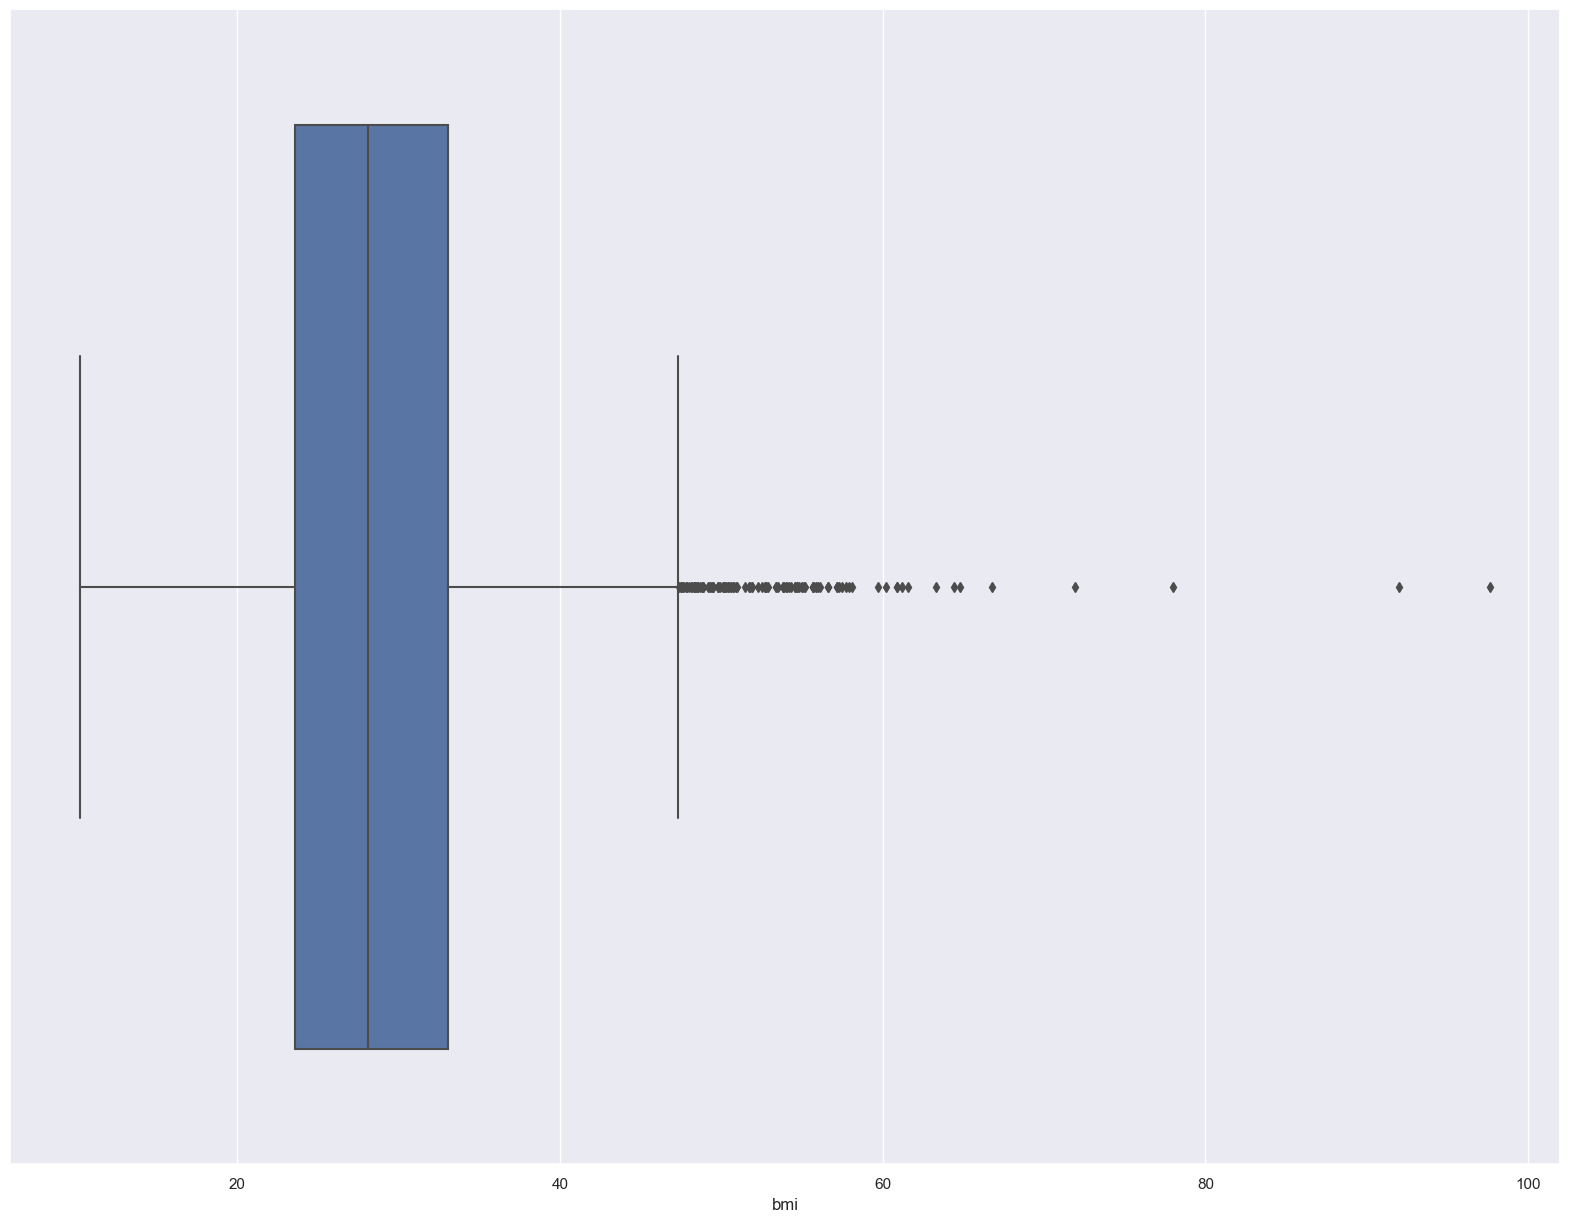

In [33]:
sns.boxplot(x=df_imp["bmi"])

<Axes: xlabel='avg_glucose_level'>

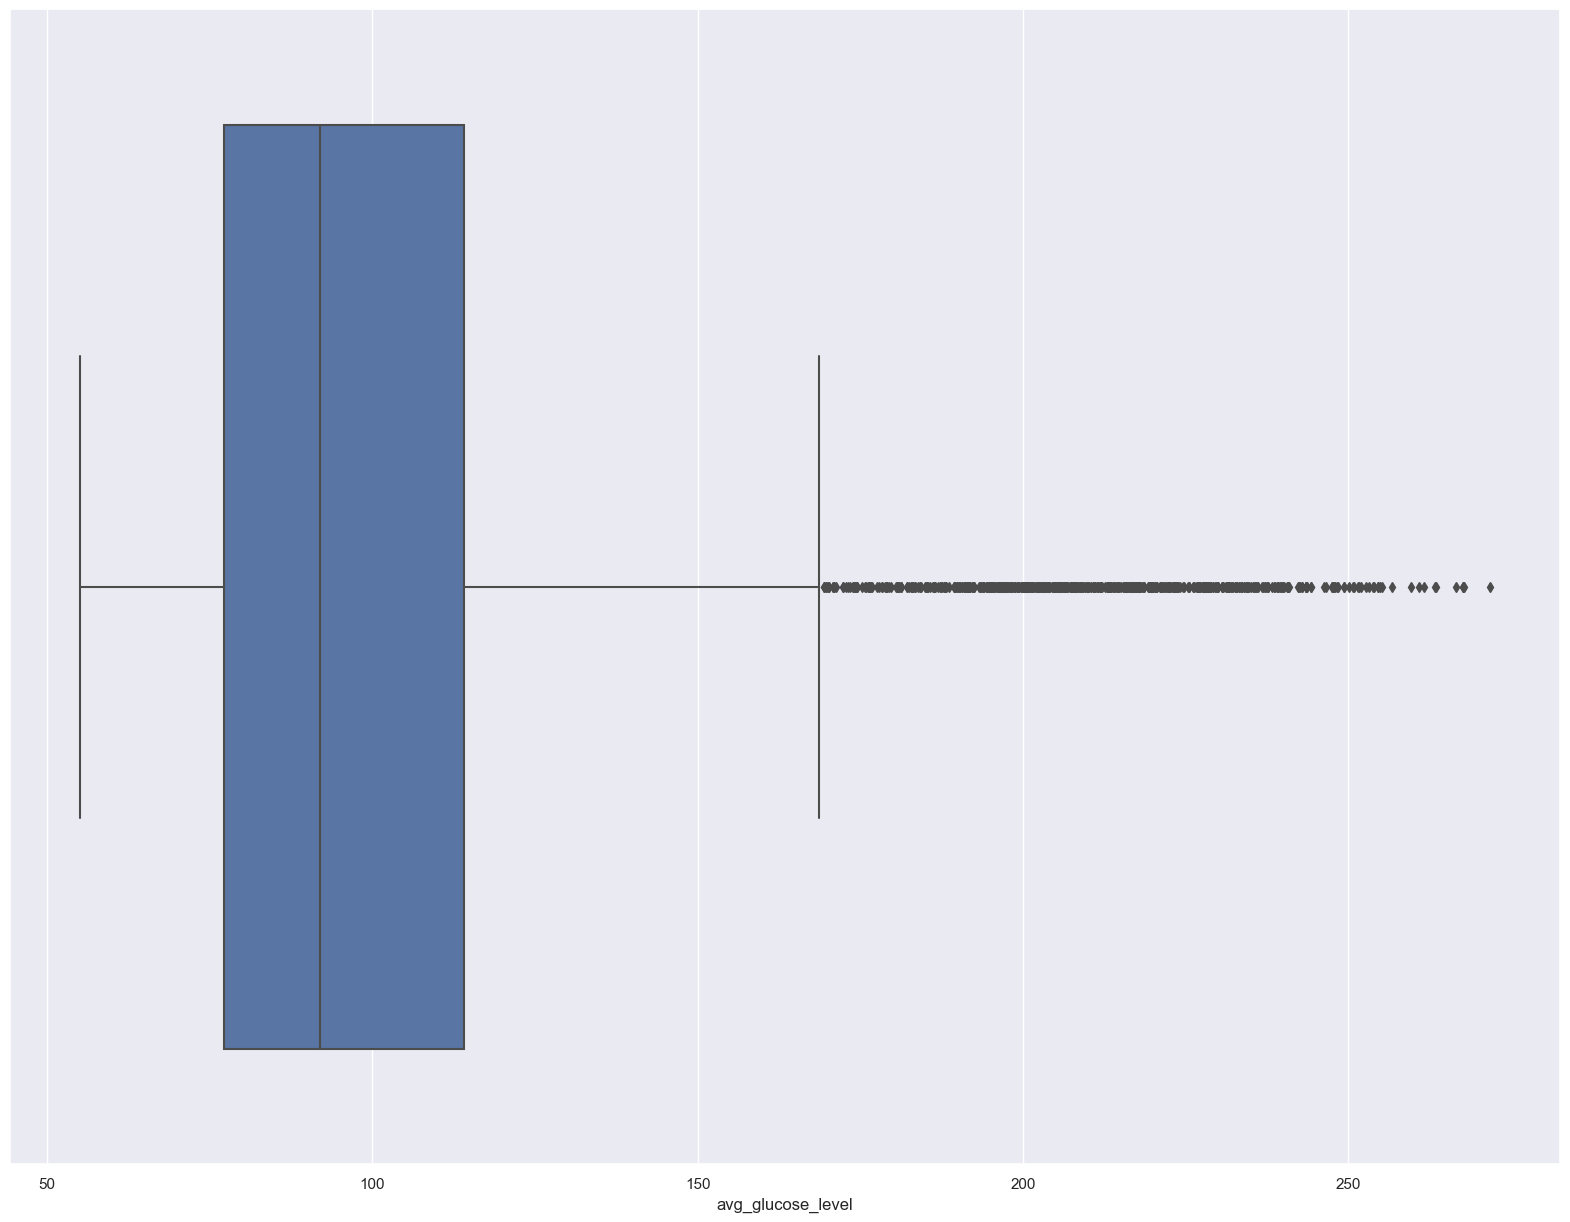

In [34]:
sns.boxplot(x=df_imp["avg_glucose_level"])

### `An Outlier can be considerd as a the datapoints which do not follow regular trend or pattern for example if we have data of age we will have max population in range 1-80 as normal human age but if someone has age of 105 or 110 which is possible wtill considerd as outlier`

**The Interquartile Range is one of technique of detecting outliers in our dataframe we detect outliers for two features `bmi` and `avg glucose level`**

In [35]:
def outliers(column):
    Q1 = np.percentile(np.sort(column),25)
    Q3 = np.percentile(np.sort(column),75)
    IQR = Q3 - Q1
    upper = Q3 + 1.5 * IQR
    lower = Q1 - 1.5 * IQR
    upper_outliers = np.where(column>upper)[0]
    lower_outliers = np.where(column<lower)[0]
    return np.concatenate([upper_outliers,lower_outliers])
    

In [36]:
outliers_bmi = outliers(df_imp["bmi"])
len(outliers_bmi)

118

In [37]:
outliers_aglevel = outliers(df_imp["avg_glucose_level"])
len(outliers_aglevel)

627

**The below list is the outliers of dataset common for both features avg_glucose_level and bmi so we can try to remove this outliers as it is common for both the features**

In [38]:
df_imp["bmi"] = np.log(df_imp["bmi"])
len(outliers(df_imp["bmi"]))

61

<Axes: xlabel='bmi'>

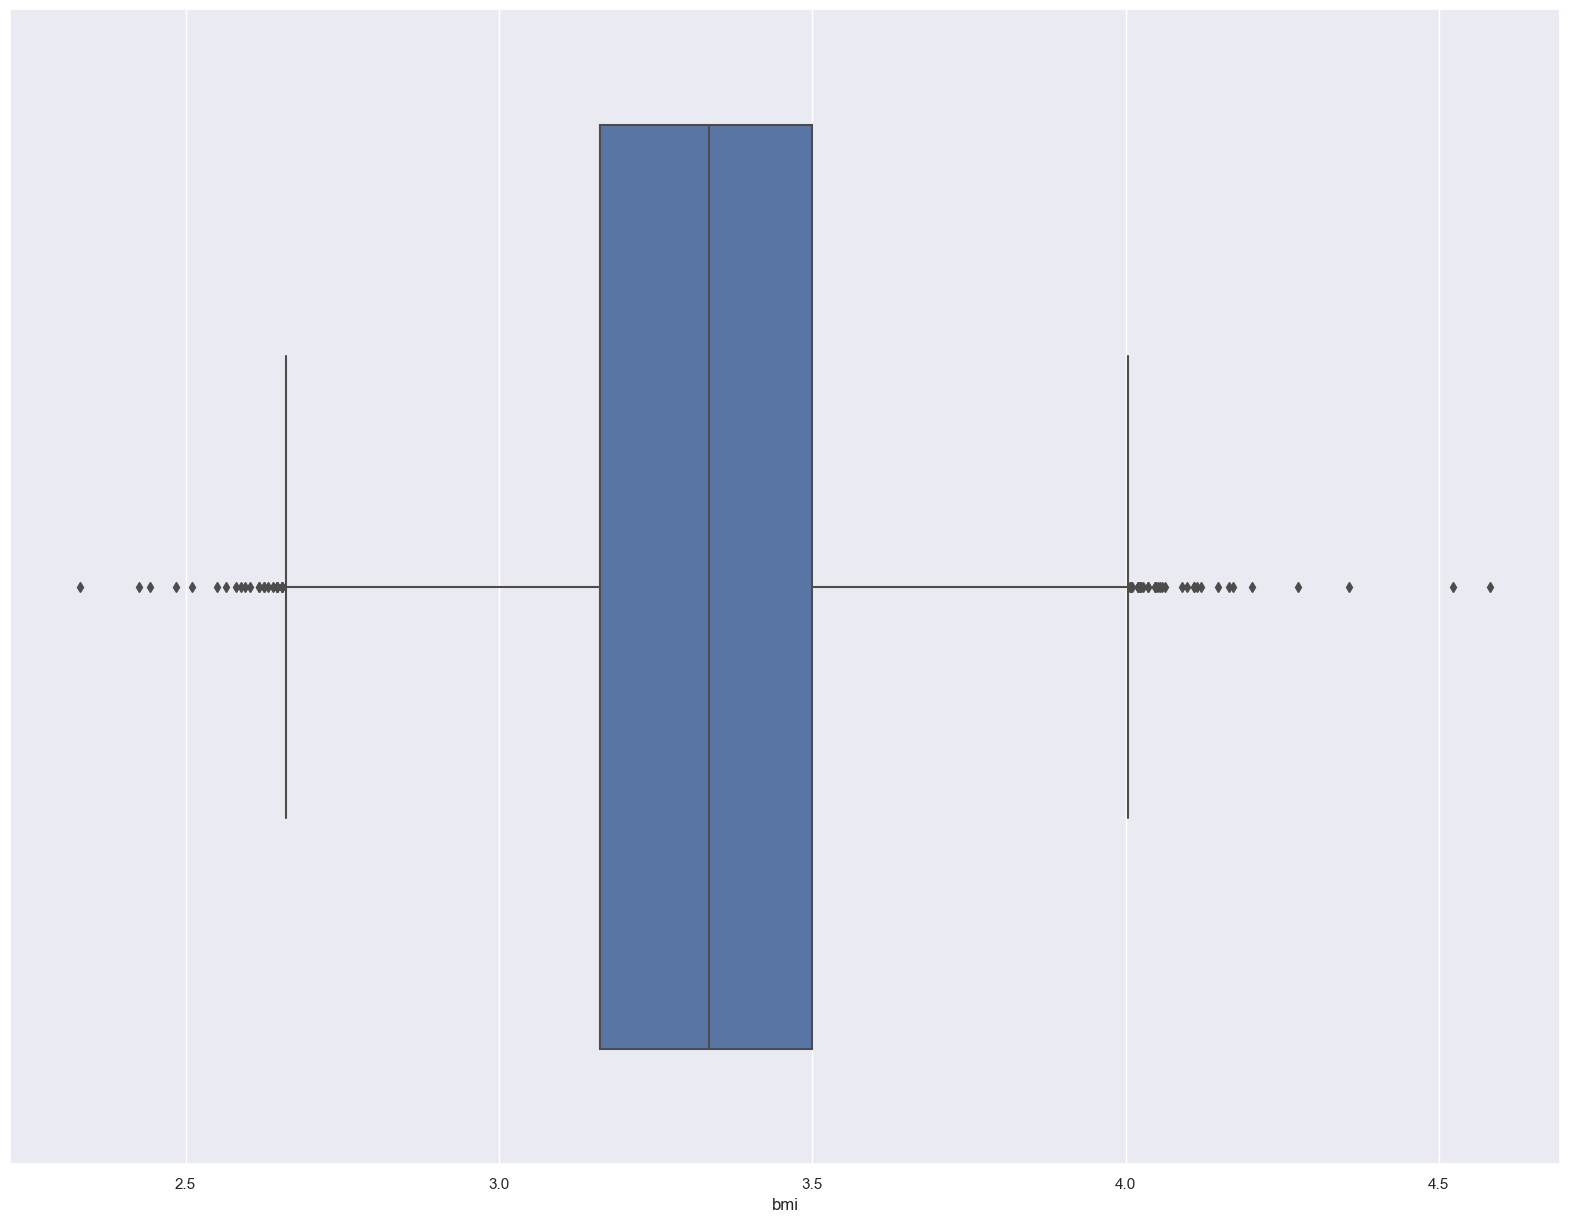

In [39]:
sns.boxplot(x=df_imp["bmi"])

In [40]:
df_imp["avg_glucose_level"] = np.log(df_imp["avg_glucose_level"])
len(outliers(df_imp["avg_glucose_level"]))

380

### NOTE : 

> **We can't remove all the outliers beacuse of two reasons outliers can be a true respresnataions**

> **Outliers help to regularize and prevent over fitting of the model** 

# Feature Engineering: 

> **During the EDA I have observed the significat realtionship between `age` and `BMI` with higher age if the BMI is higher The individula is more likely to have a** `stroke`

> **So we can basically have a product of both the coulumns and just use one attribute `BMI_age_product` insted of both** 

> Link for refrence : https://www.cdc.gov/nccdphp/dnpa/growthcharts/training/modules/module1/text/module1print.pdf



In [41]:
df_imp['bmi_age_product'] = df_imp['bmi']*df_imp['age']

> **During the EDA I have observed that when both the `heart_disease` and `Hypertension` were True (1) there was a very critical chance of having a stroke**

> **So we can basically have a product or `and` opeation both the coulumns and just use one attribute `hypertension_and_heart_disease` insted of both** 

> Link for refrence : https://my.clevelandclinic.org/health/diseases/21840-hypertensive-heart-disease

In [42]:
df_imp['hypertension_and_heart_disease'] =  ((df_imp["hypertension"]==1)&(df_imp["heart_disease"]==1))
df_imp["hypertension_and_heart_disease"].replace(False,0,inplace=True)
df_imp["hypertension_and_heart_disease"].replace(True,1,inplace=True)
df_imp.head(3)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,gender_Male,gender_Other,ever_married_Yes,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,bmi_age_product,hypertension_and_heart_disease
0,67.0,0.0,1.0,5.432367,3.600048,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,241.203232,0
1,61.0,0.0,0.0,5.309307,3.457893,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,210.931456,0
2,80.0,0.0,1.0,4.662684,3.481240,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,278.499207,0


In [43]:
from sklearn.preprocessing import MinMaxScaler

# StandardScaler

Scaling is used inorder to make data normal most of the machine learning models assume data is normal
hence having a normally distributed data helps model learn better


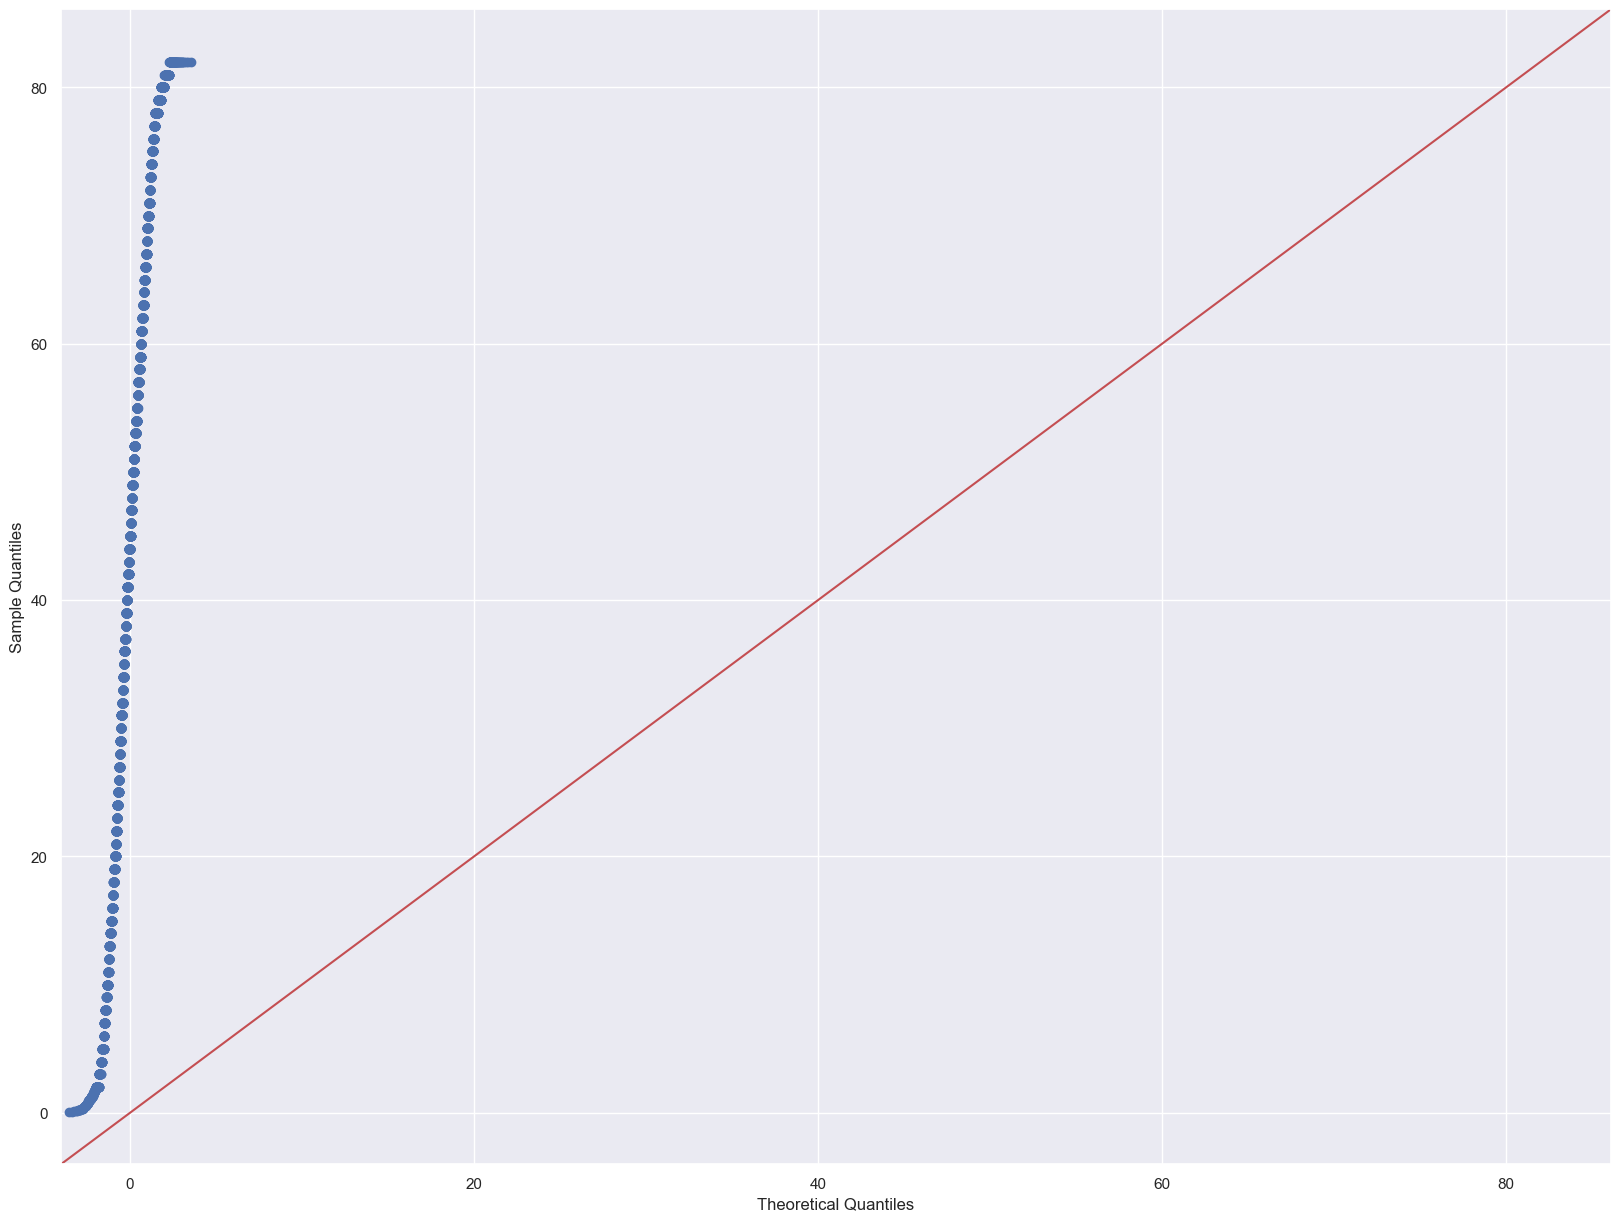

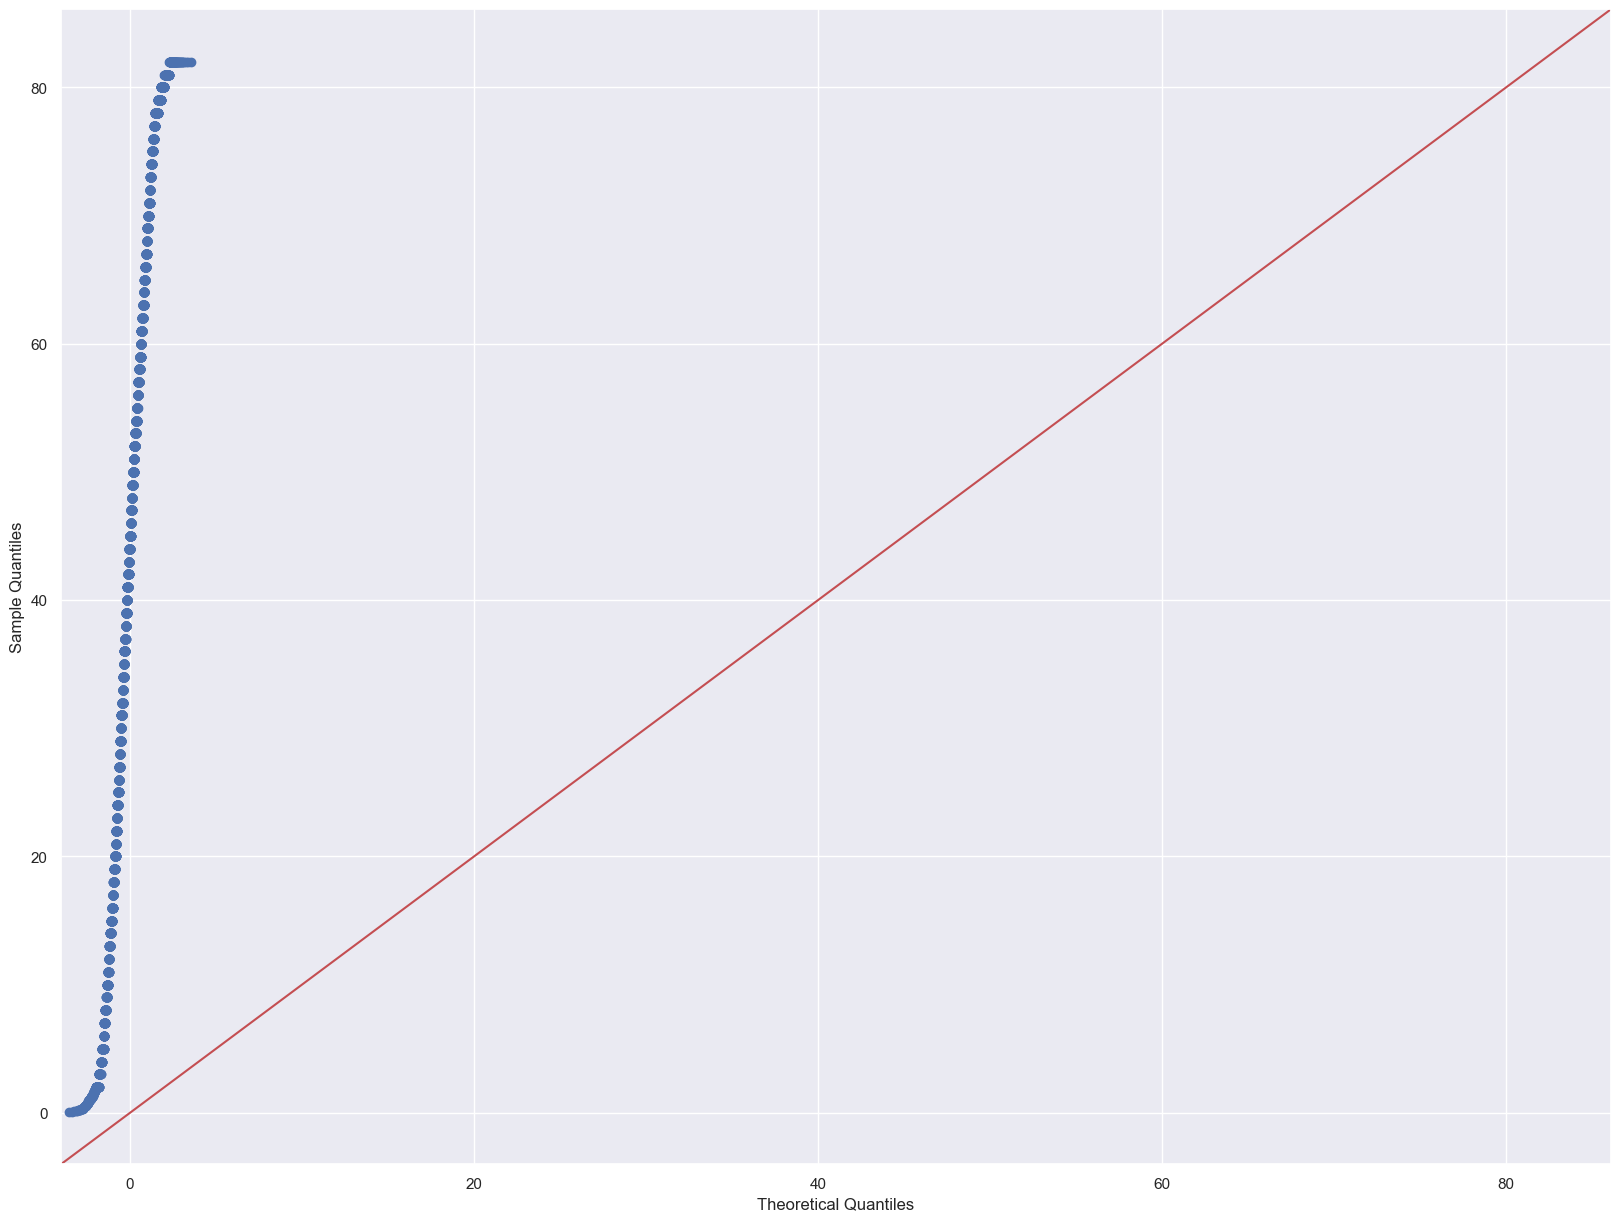

In [44]:
sm.qqplot(df_imp["age"],line='45')



In [49]:
scaler = StandardScaler()
df_imp[["avg_glucose_level","bmi","age", "bmi_age_product"]]  = pd.DataFrame(scaler.fit_transform(df_imp[["avg_glucose_level","bmi","age", "bmi_age_product"]].values),columns=["avg_glucose_level","bmi","age","bmi_age_product"],index=df_imp.index)

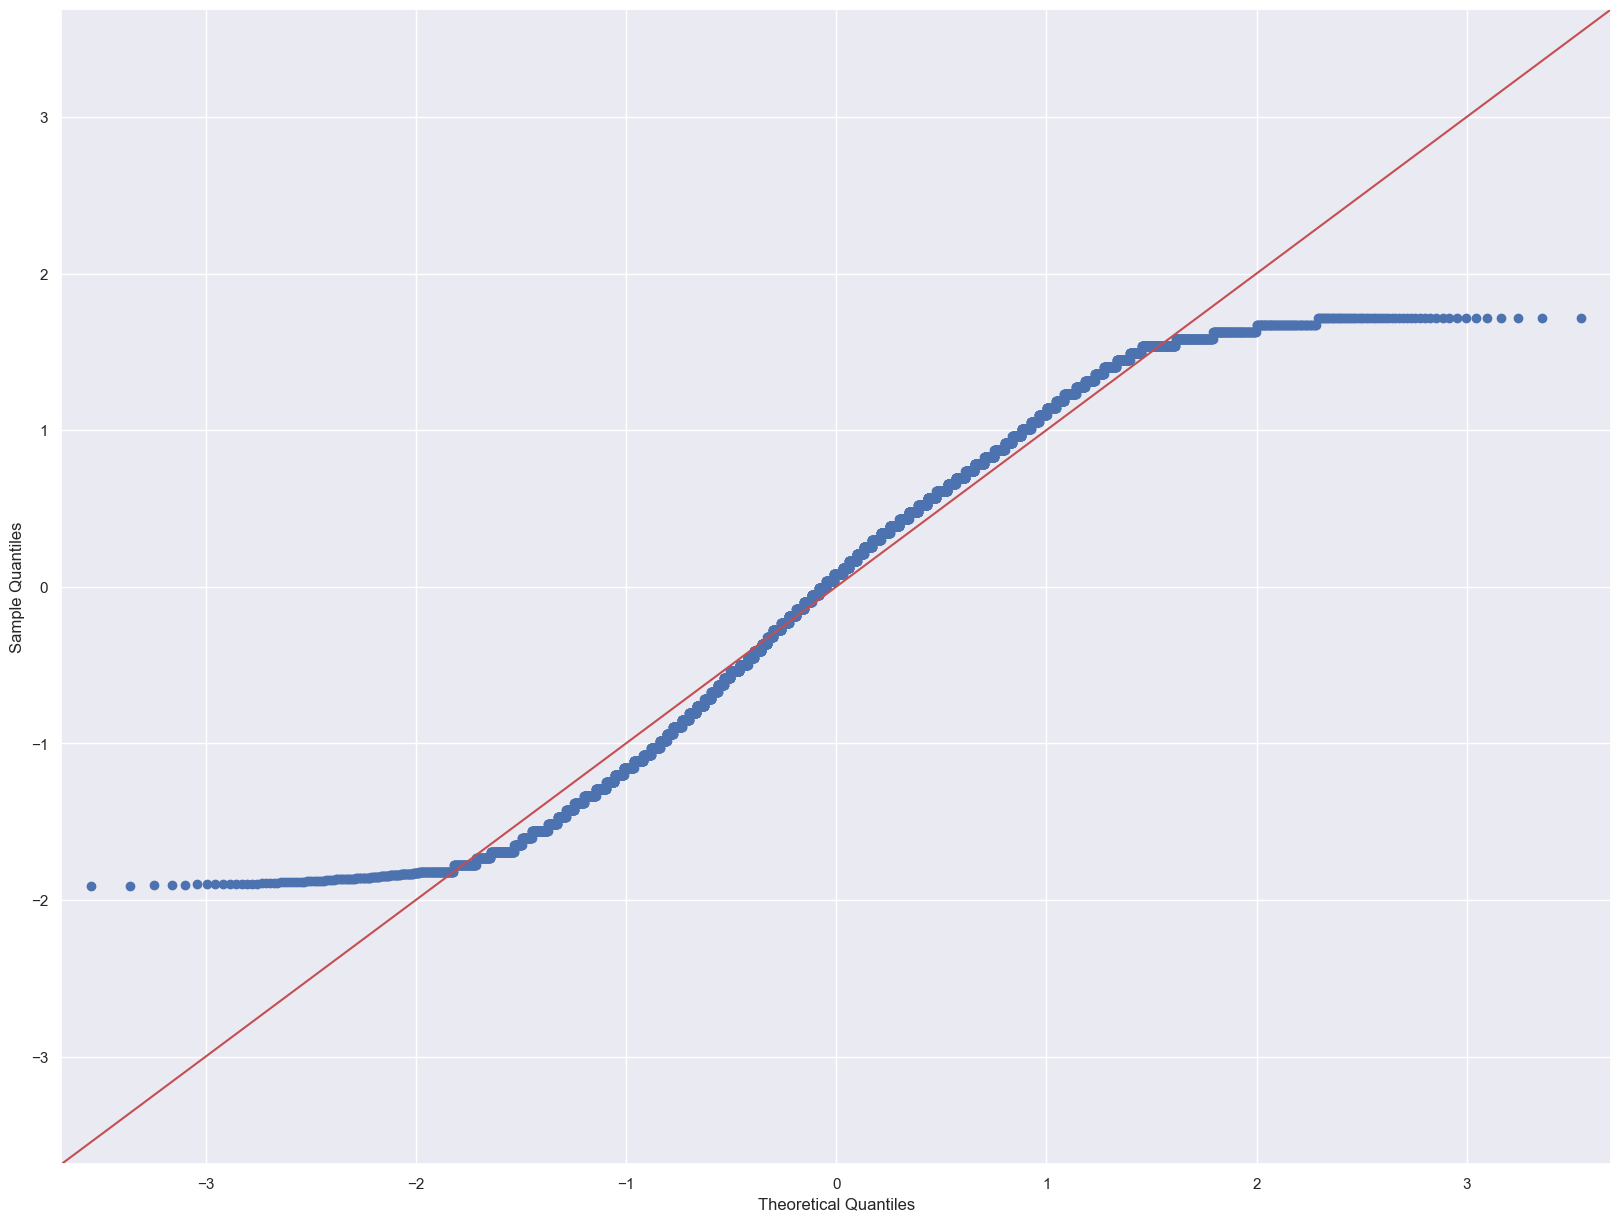

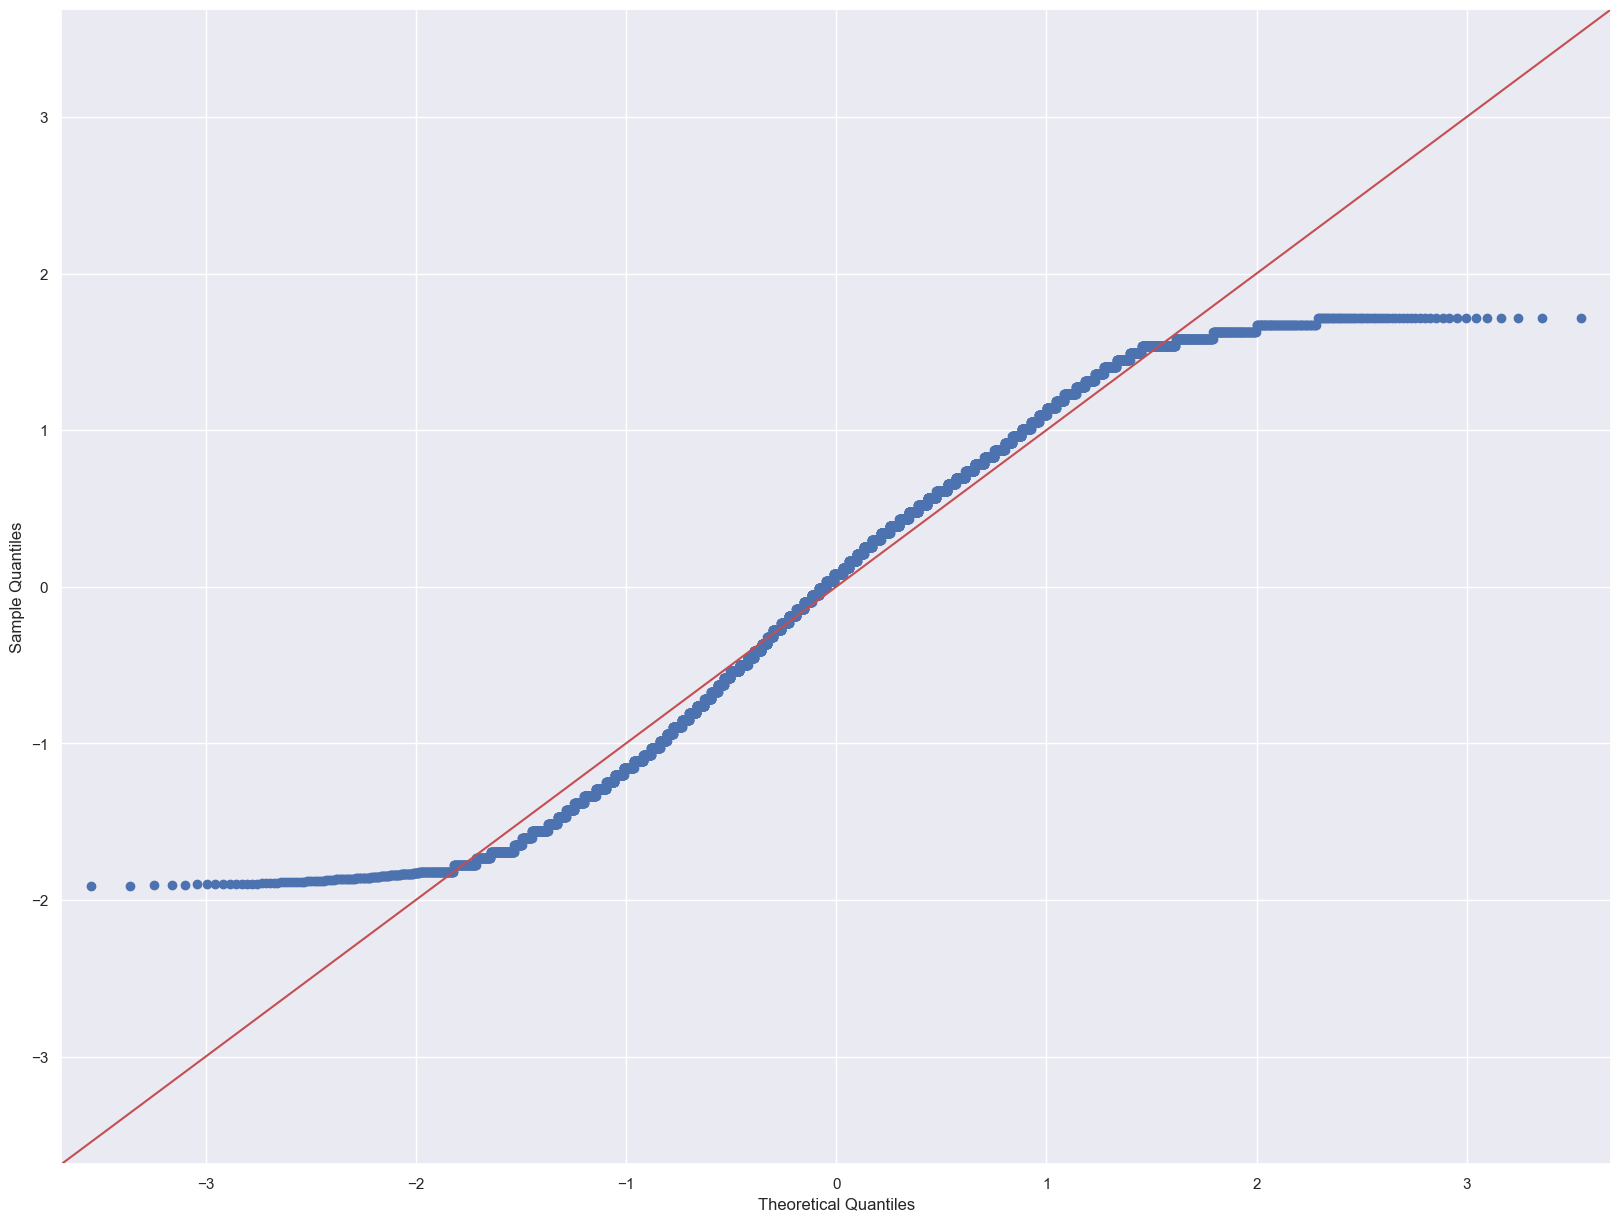

In [50]:
sm.qqplot(df_imp["age"],line='45')

### NOTE :

> After Standard scaler we can see the distribution has been converted to more over normal one in the range of -2 to 2

In [52]:
df_imp.to_csv('scaled_feature_engineered_data_stroke.csv')